In [1]:
from stable_baselines3 import PPO

from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper, DiscreteActionWrapper
from citylearn.data import DataSet

from art.estimators.classification import PyTorchClassifier as classifier
from art.attacks.evasion import AutoConjugateGradient as ACG

from torch.nn import CrossEntropyLoss

from tqdm import tqdm

import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
dataset_name = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

In [3]:
schema = DataSet.get_schema(dataset_name)

In [4]:
def make_discrete_env(schema, action_bins: int = 10, bldg: list = ['Building_1'], single_agent: bool = True, seed:int = 0):
    """Because ART's attacks are designed for supervised learning they one work with ANNs with a single label or head, using multiple buildings adds an action/head for each"""
    env = CityLearnEnv(schema, 
        central_agent=single_agent, 
        buildings=bldg, 
        random_seed=seed)
    #Because ART attacks are made for classification tasks we need a discrete action space 
    env = DiscreteActionWrapper(env, bin_sizes=[{'electrical_storage':action_bins}])
    #Calendar observations are periodically normalized, everything else is min/max normalized 
    env = NormalizedObservationWrapper(env)
    #provides an interface for SB3
    env = StableBaselines3Wrapper(env)
    return env

Train victim agent (Python: Launch Tensorboard)

In [5]:
agent_name = f'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_SolarPenaltyReward_300.zip'

agent = PPO.load(path=f"Models/Victim/{agent_name}")
print('Model loaded from storage')

Model loaded from storage


In [6]:
building = list(schema['buildings'].keys())[0] #the first building from the schema's building keys
bins = agent.action_space[0].n
env = make_discrete_env(schema=schema, 
                        bldg=[building], 
                        action_bins=bins,
                        seed=42)

In [7]:
def format_kpis(env):
    """displays the KPIs from the evnironment's most recent timestep.
    This function can be called after an agent runs in a test env to evaluate performance"""

    kpis = env.evaluate().pivot(index='cost_function', columns='name', values='value')
    kpis = kpis.dropna(how='all')
    kpis = kpis['District']
    kpis = kpis[kpis != 0]
    return kpis

In [34]:
def eval_agent(env, agent):
    """displays the KPIs for each building and district
    ref quickstart"""
    obs_list = []
    a_list = []

    observations = env.reset()

    while not env.done:
        obs_list.append(observations)
        actions, _ = agent.predict(observations, deterministic=True)
        a_list.append(actions)
        observations, _, _, _ = env.step(actions)
    #obs_list.append(observations) #no action take for this observation
    
    return format_kpis(env), np.array(obs_list), np.array(a_list)

In [ ]:
def extract_actor(agent):
    """Extracts the policy network from and SB3 actor critic algorithm as a pytorch seuqential network"""
    from copy import deepcopy
    policy_net = deepcopy(agent.policy.mlp_extractor.policy_net) #copies shared net rather than referencing
    policy_net.add_module('actions', agent.policy.action_net)
    return policy_net

In [36]:
def get_feature_permutations(agent, observations:np.array, actions: np.array, FeaturePermuation_kwargs: dict=None) -> np.array:
    from captum.attr import FeaturePermutation
    import torch

    tensor_obs = torch.from_numpy(observations).type(torch.FloatTensor).to('cuda')
    actor = extract_actor(agent)
    fp = FeaturePermutation(actor)
    attr = fp.attribute(tensor_obs, 
                    target=actions.flatten().tolist())
    attr = attr.detach().cpu().numpy()

    return np.mean(attr, axis=0)

Unperturbed agent performance

In [35]:
baseline_kpis, baseline_obs, baseline_a = eval_agent(env,agent)
display(baseline_kpis)

cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.912968
cost_total                               0.843721
daily_one_minus_load_factor_average      1.020092
daily_peak_average                       0.946376
electricity_consumption_total            0.929703
monthly_one_minus_load_factor_average    0.986593
ramping_average                          1.074427
zero_net_energy                          1.079451
Name: District, dtype: float64

We'll prepare an index with our feature names, since CityLearn does not name them properly

In [10]:
index = env.observation_names[0]
#add second index for periodic features
for i in [1,3,5]:
    index.insert(i, index[i-1] + '_cos')
#add suffix for other periodic features
for i in [0,2,4]:
    index[i] += '_sin'

Compared to the feature permuations from the base reward (20 bin PPO), we note:
- the realative increase in importance of teh non_shiftable load as it has moved up on spot in the ranking
- Hour_sin and SOC have stiwtch places, though 1st and 2nd place have similar importances. With this reward, the agent has learned to rely on the hour more than any other feature, which may partially explain it's inferior KPIs.
- The first 6 feature have relatively larger importances

In [37]:
attributions = get_feature_permutations(agent, baseline_obs, baseline_a)
attributions = pd.Series(attributions, index=index)
display(attributions.sort_values(ascending=False))

hour_sin                                      2.526781
electrical_storage_soc                        1.864900
hour_cos                                      1.474325
month_sin                                     1.145200
non_shiftable_load                            0.976903
day_type_sin                                  0.914835
day_type_cos                                  0.730083
diffuse_solar_irradiance_predicted_12h        0.632489
month_cos                                     0.498689
electricity_pricing_predicted_12h             0.361668
direct_solar_irradiance_predicted_12h         0.317365
diffuse_solar_irradiance_predicted_6h         0.305200
electricity_pricing_predicted_6h              0.243570
direct_solar_irradiance                       0.208529
electricity_pricing                           0.143342
direct_solar_irradiance_predicted_24h         0.141799
outdoor_dry_bulb_temperature                  0.104915
diffuse_solar_irradiance                      0.101073
outdoor_dr

In [11]:
df_baseline_obs = pd.DataFrame(baseline_obs, columns=index)

<Axes: >

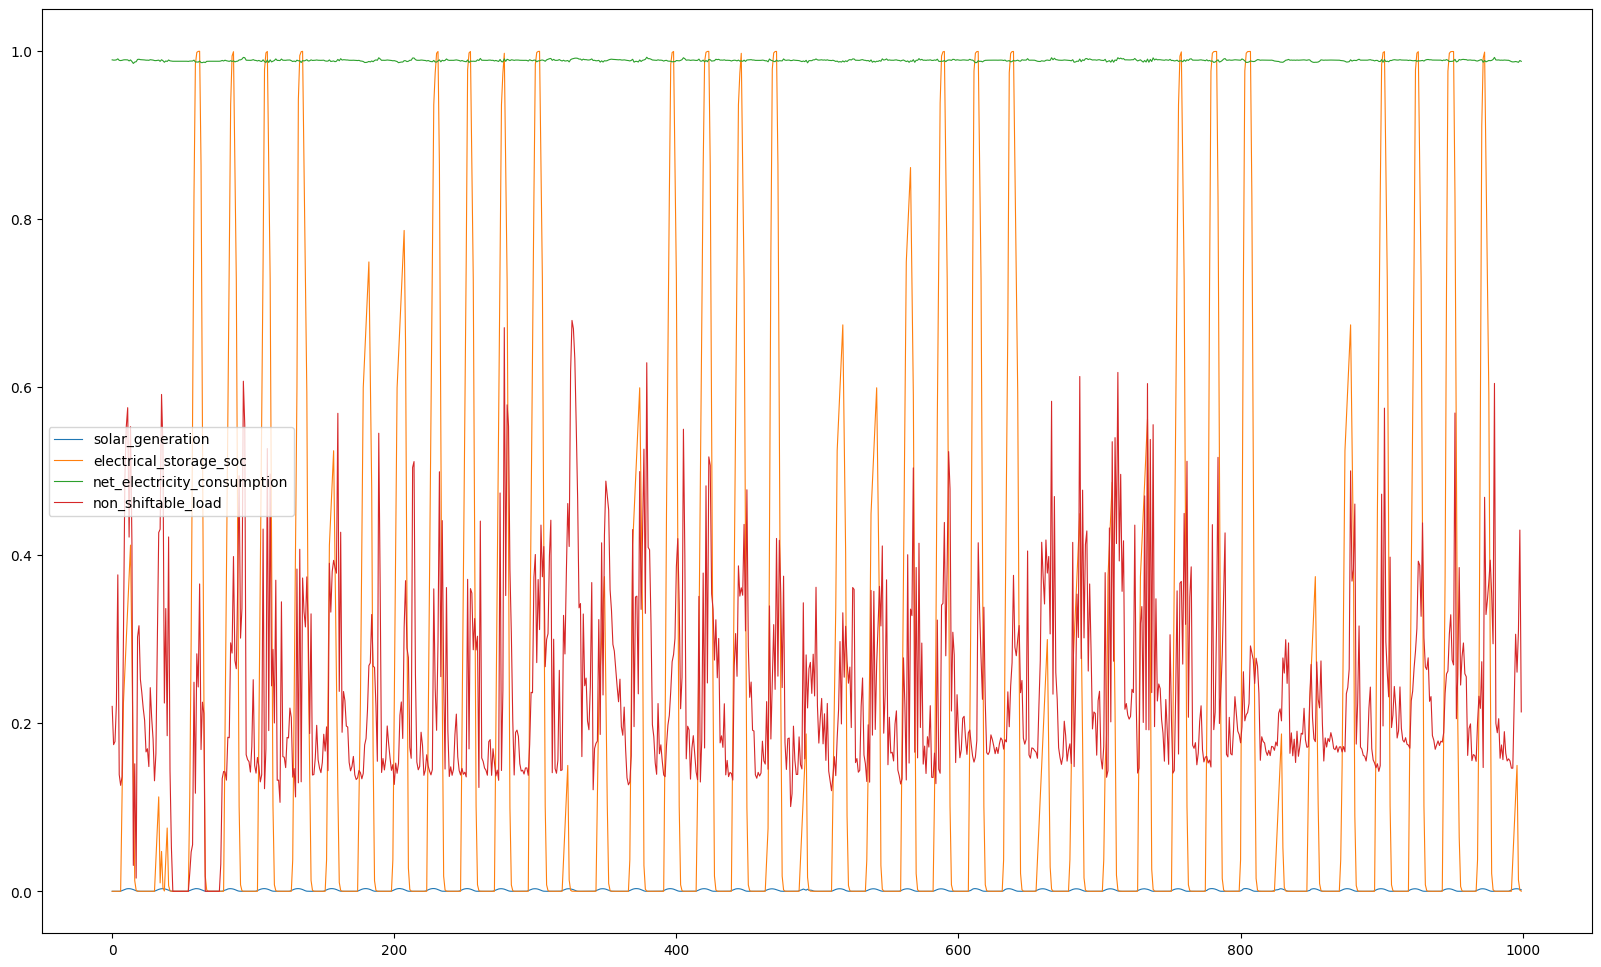

In [12]:
df_baseline_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:1000].plot.line(figsize=(20,12), lw=0.8)

In [13]:
def eval_rand_attack(agent, env, eps=0.3):
    """displays the KPIs for each building and district withc random noise in the observations
    ref quickstart"""
    obs_list = []
    asr = 0

    observations = env.reset()
    
    while not env.done:
        obs_list.append(observations)
        noisey_obs = observations + np.random.rand(*observations.shape)*eps
        a_adv, _ = agent.predict(noisey_obs, deterministic=True)
        actions, _ = agent.predict(observations, deterministic=True)
        if a_adv!=actions: #check if the perturbation changed the agent's action
            asr+=1
        observations, _, _, _ = env.step(a_adv)
    obs_list.append(observations)

    asr/=env.time_steps
    print(f'The Adversarial success rate is: {asr}')
    return format_kpis(env), np.array(obs_list)

Model performance while observations are perturbed by random noise [0,1). Note that all the observation values are normalized to [0,1]

In [14]:
rand_kpis, rand_obs = eval_rand_attack(agent, env, eps=0.3)

The Adversarial success rate is: 0.45821917808219176


Here's the regret for the random attack:

In [15]:
display(baseline_kpis - rand_kpis)

cost_function
annual_peak_average                      0.000000
carbon_emissions_total                  -0.064385
cost_total                              -0.097099
daily_one_minus_load_factor_average     -0.088213
daily_peak_average                      -0.038339
electricity_consumption_total           -0.054406
monthly_one_minus_load_factor_average   -0.007023
ramping_average                         -0.106253
zero_net_energy                          0.020688
Name: District, dtype: float64

In [16]:
df_rand_obs = pd.DataFrame(rand_obs, columns=index)

<Axes: >

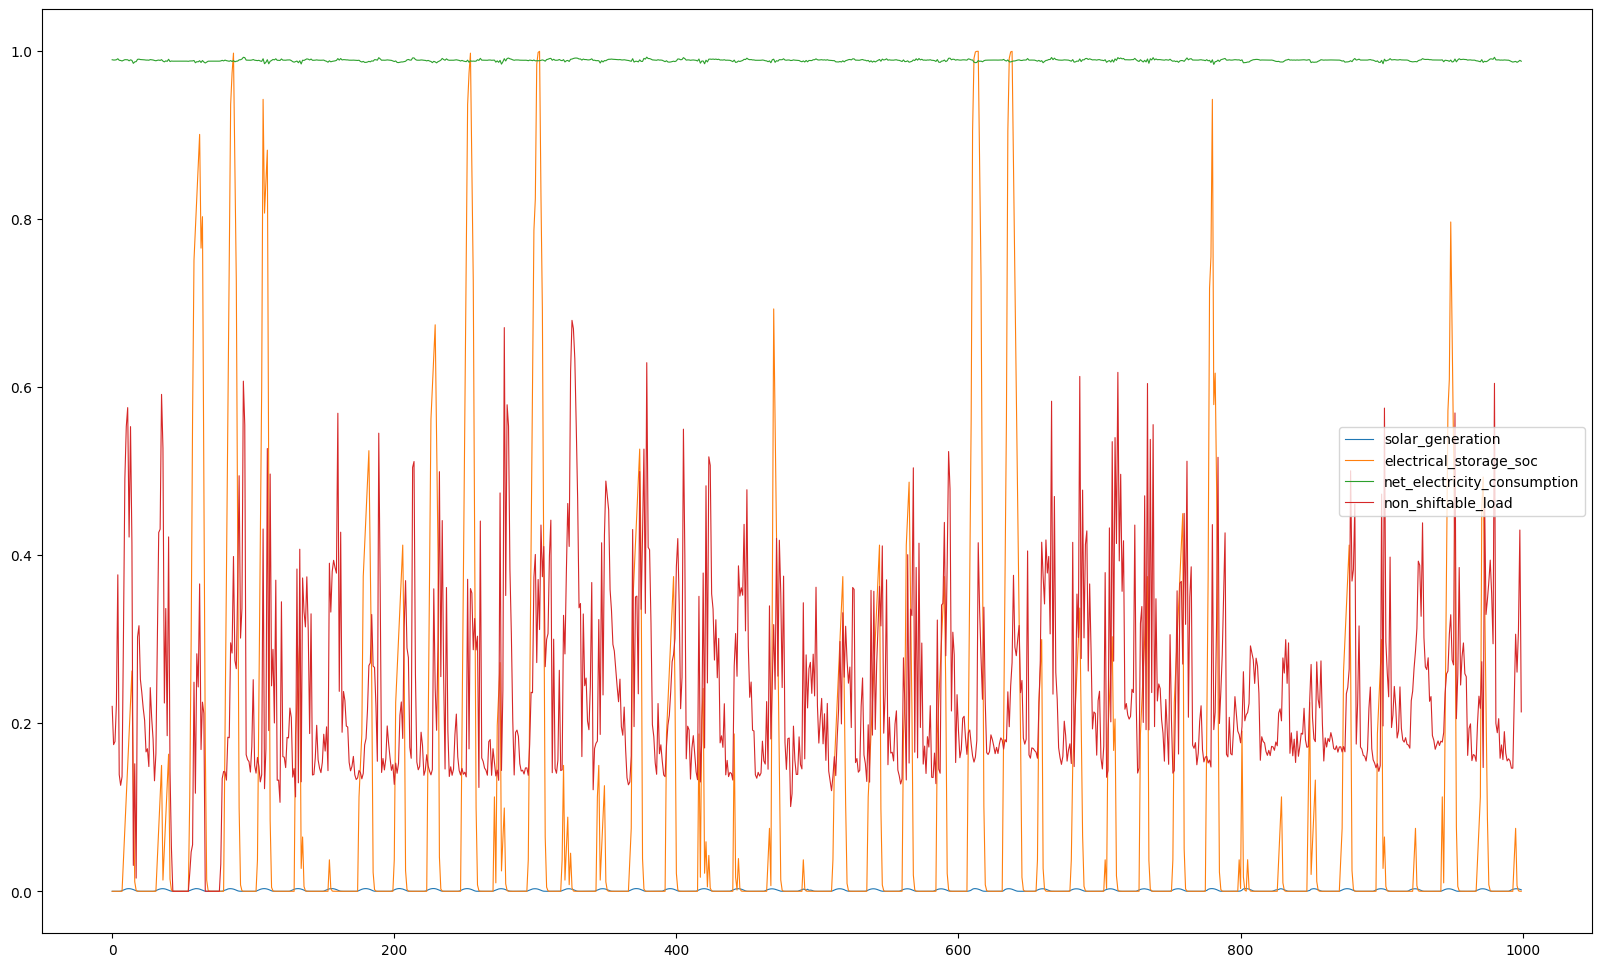

In [17]:
df_rand_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:1000].plot.line(figsize=(20,12), lw=0.8)

Define our gradient based attack:

In [19]:
def define_attack(agent, env, ART_atk, loss_fn=CrossEntropyLoss(), **kwargs):
    """returns an ART attack function based on the input gym enviornment, SB3 Agent and ART attack class"""
    
    agent_policy = extract_actor(agent)

    victim_policy = classifier(
        model=agent_policy,
        loss=loss_fn, 
        nb_classes=env.action_space[0].n,
        input_shape=agent.observation_space.shape,
        device_type='gpu'
        )

    return ART_atk(estimator=victim_policy, verbose=False, **kwargs)

In [20]:
def eval_untargeted_attack(agent, env, atk, time_steps:int=None, mask:list=None):
    """Evaluates an SB3 agent subject to untargeted observation perturbations generated by an ART evasion attack"""
    obs_list = []
    asr = 0

    observations = env.reset()
    #failed_adv_exs = 0
    if time_steps is None:
        time_steps = env.time_steps - 1
    if mask is None:
        mask=np.ones(agent.observation_space.shape[0]) #1 for all features

    for _ in tqdm(range(time_steps)):

        obs_list.append(observations)

        adv_obs = np.expand_dims(observations, axis=0) #ART atks expect a 2d array
        #would using the true label/action imporve the asr? it would hurt adversarial training: https://arxiv.org/abs/1611.01236
        adv_obs = atk.generate(adv_obs, mask=mask)
        adv_obs = np.squeeze(adv_obs) #CityLearn envs expect a 1d array
        
        a_adv, _ = agent.predict(adv_obs, deterministic=True)
        #actions, _ = agent.predict(observations, deterministic=True)
        if not np.array_equal(adv_obs, observations): #check if an adversarial example was crafted
            asr+=1
        #if a_adv!=actions: #check if the perturbation changed the agent's action
        #    asr+=1
        #elif np.array_equal(adv_obs, observations): #when the victim's action is unchanged, check if an adv observation was crafted
        #    failed_adv_exs+=1
        observations, _, _, _ = env.step(a_adv)

        if env.done:
            break
    
    obs_list.append(observations)
    asr/=time_steps
    print(f'The Adversarial success rate is: {asr}')
    #print(f'{failed_adv_exs} adversarial examples were produced but failed to change the victim\'s action')
    return format_kpis(env), np.array(obs_list)

In [21]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.05, #default 0.3,
    eps_step=0.02, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = define_attack(agent, env, ACG, **ACG_parameters)

Before attacking the victim, we must understand what we are perturbing. So we need to see which observations/features are active in the environment (NB that periodically normalized calendar features are not properly named by the environment, so we will do it ourselves ref: https://github.com/intelligent-environments-lab/CityLearn/issues/74 ):

In [22]:
observation_masks = pd.Series(1, index=index).to_frame(name='all')

It seems that all these observations are variable (changes to constant values would indicate perturbations), however perturbations to the date and time would be obvious to an analyst. We will mask these features in our attack so they will not be perturbed.

In [23]:
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [24]:
observation_masks

,all,mask_time
month_sin,1,0
month_cos,1,0
day_type_sin,1,0
day_type_cos,1,0
hour_sin,1,0
hour_cos,1,0
outdoor_dry_bulb_temperature,1,1
outdoor_dry_bulb_temperature_predicted_6h,1,1
outdoor_dry_bulb_temperature_predicted_12h,1,1
outdoor_dry_bulb_temperature_predicted_24h,1,1


Plot for preliminary results:
- outdoor_dry_bulb_temperature
- solar_generation
- electrical_storage_soc
- net_electricity_consumption
- electricity_pricing
- calculate power from grid/aggregate load

In [25]:
Adv_untargered_kpis, adv_obs = eval_untargeted_attack(agent, env, attack, time_steps=1000, mask=observation_masks['mask_time'].to_numpy())
display(baseline_kpis - Adv_untargered_kpis)

100%|██████████| 1000/1000 [11:30<00:00,  1.45it/s]

The Adversarial success rate is: 1.0


cost_function
annual_peak_average                     -0.053665
carbon_emissions_total                  -0.054642
cost_total                              -0.028404
daily_one_minus_load_factor_average      0.064183
daily_peak_average                      -0.008528
electricity_consumption_total           -0.059486
monthly_one_minus_load_factor_average   -0.011899
ramping_average                         -0.203693
zero_net_energy                          0.029662
Name: District, dtype: float64

The adversarial regret from the untargeted adversarial attack is:

In [26]:
display(baseline_kpis - Adv_untargered_kpis)

cost_function
annual_peak_average                     -0.053665
carbon_emissions_total                  -0.054642
cost_total                              -0.028404
daily_one_minus_load_factor_average      0.064183
daily_peak_average                      -0.008528
electricity_consumption_total           -0.059486
monthly_one_minus_load_factor_average   -0.011899
ramping_average                         -0.203693
zero_net_energy                          0.029662
Name: District, dtype: float64

In [27]:
df_adv_obs = pd.DataFrame(adv_obs, columns=index)

<Axes: >

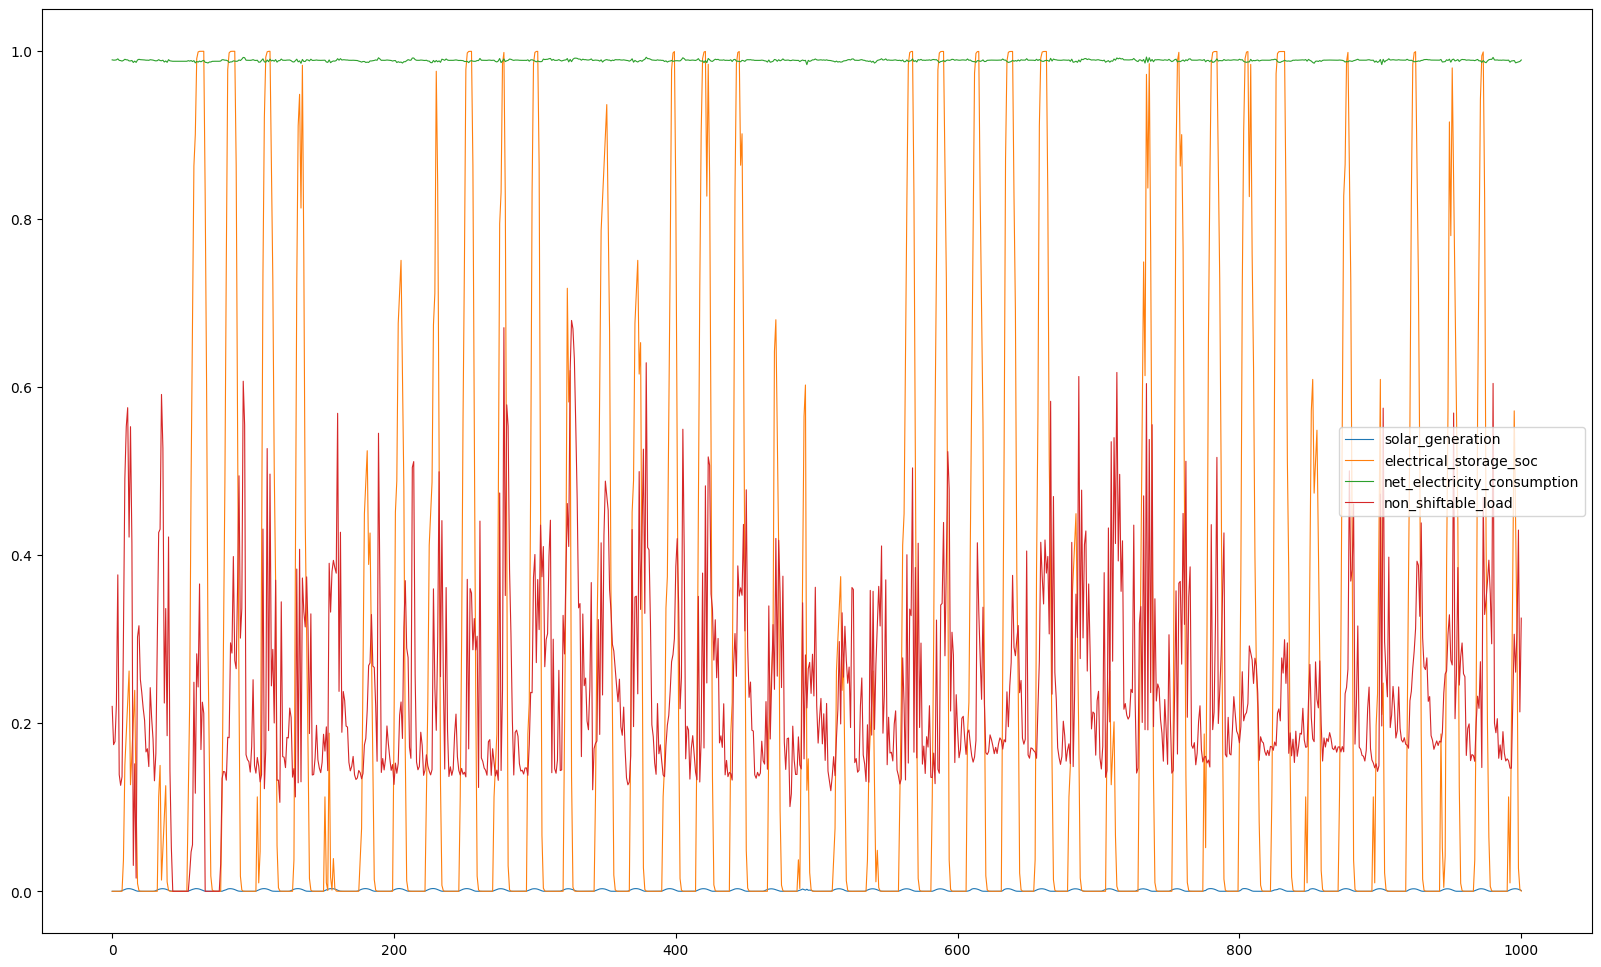

In [28]:
df_adv_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]].plot.line(figsize=(20,12), lw=0.8)

We could mask other features where tampering would be obvious e.g. temperture predictions vary between observations, but pricing predictions are identical for many obvservations and vary predictably.

In [29]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.025, #default 0.3,
    eps_step=0.02, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = define_attack(agent, env, ACG, **ACG_parameters)
Adv_untargered_kpis, adv_obs = eval_untargeted_attack(agent, env, attack, time_steps=1000, mask=observation_masks['mask_time'].to_numpy())

100%|██████████| 1000/1000 [17:41<00:00,  1.06s/it]

The Adversarial success rate is: 1.0


In [30]:
display(Adv_untargered_kpis)

cost_function
annual_peak_average                      0.986975
carbon_emissions_total                   0.954681
cost_total                               0.859920
daily_one_minus_load_factor_average      0.938472
daily_peak_average                       0.918470
electricity_consumption_total            0.975496
monthly_one_minus_load_factor_average    0.971452
ramping_average                          1.168556
zero_net_energy                          1.048227
Name: District, dtype: float64

In [31]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.0125, #default 0.3,
    eps_step=0.007, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = define_attack(agent, env, ACG, **ACG_parameters)
Adv_untargered_kpis, adv_obs = eval_untargeted_attack(agent, env, attack, time_steps=1000, mask=observation_masks['mask_time'].to_numpy())
display(Adv_untargered_kpis)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [24:29<00:00,  1.47s/it]

The Adversarial success rate is: 1.0


cost_function
annual_peak_average                      0.998242
carbon_emissions_total                   0.937072
cost_total                               0.849741
daily_one_minus_load_factor_average      0.924268
daily_peak_average                       0.901422
electricity_consumption_total            0.956750
monthly_one_minus_load_factor_average    0.986308
ramping_average                          1.111914
zero_net_energy                          1.045480
Name: District, dtype: float64

In [32]:
df_adv_obs = pd.DataFrame(adv_obs, columns=index)

<Axes: >

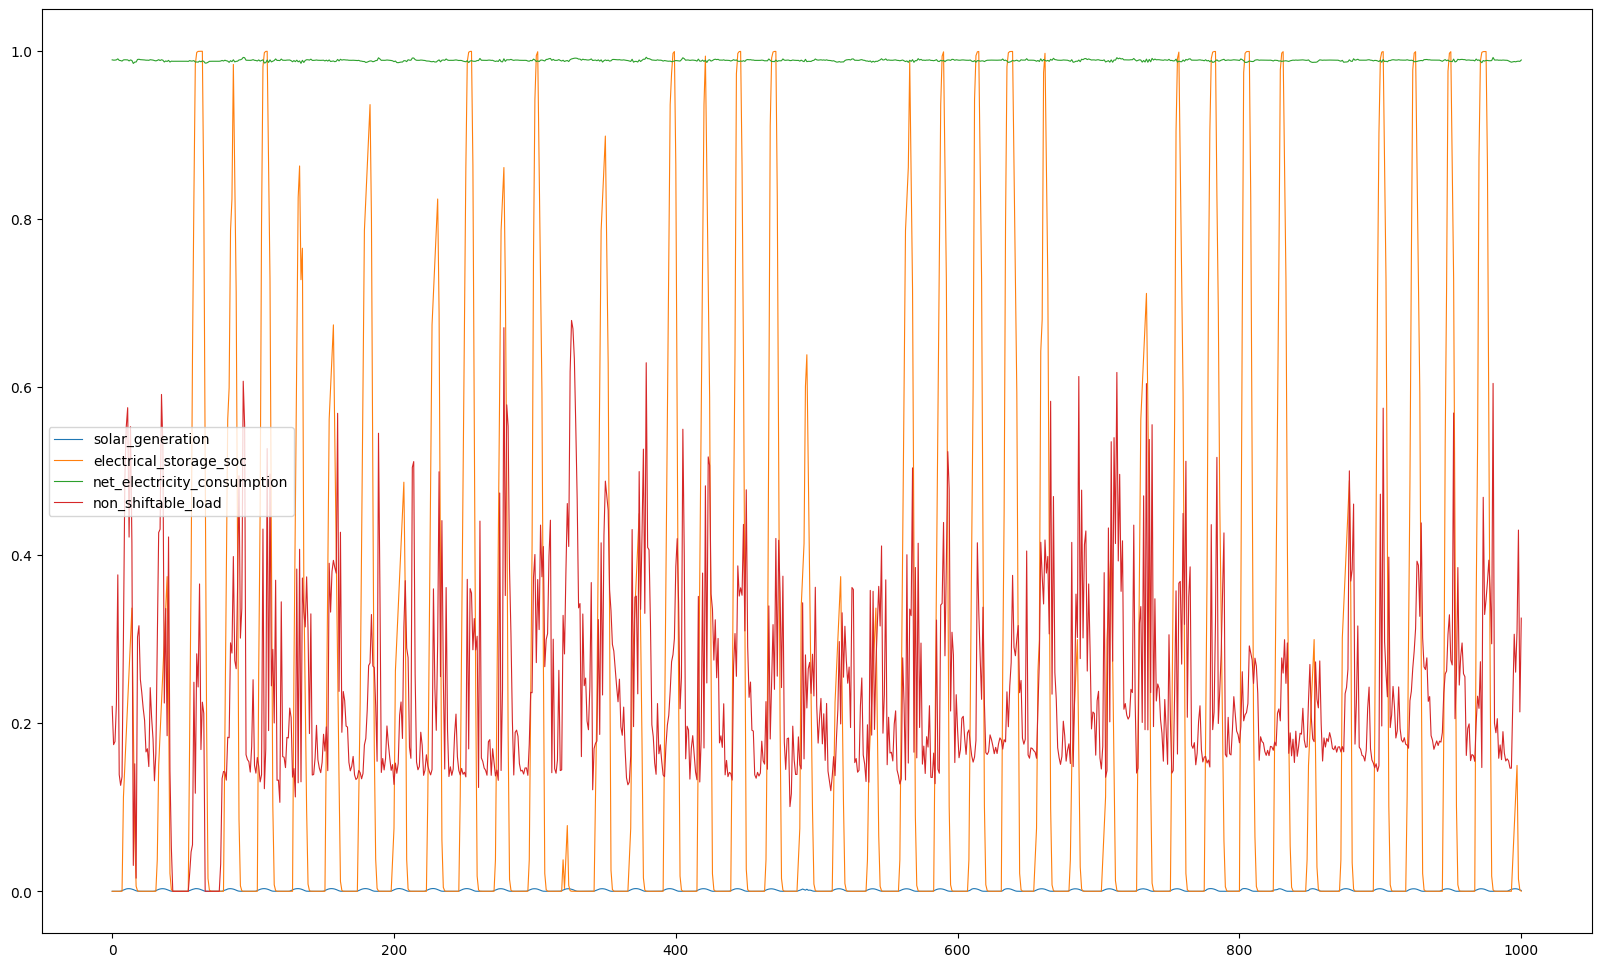

In [33]:
df_adv_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]].plot.line(figsize=(20,12), lw=0.8)

Evaluate agent with variable epsilon:
- Start at min value and increase in loop
- try multiple values in parallel
- return stat on the eps used, box plot?